In [1]:
import os
os.chdir('./backend/app/')
import torch
from transformers import AutoModel, AutoTokenizer
from pprint import pprint
from helpers.tesseract_utils import Tesseract
import pandas as pd
import cv2
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from helpers import text_utils
from helpers import es_utils
from helpers import image_utils
from helpers import scanner
from elasticsearch import Elasticsearch
from sklearn.utils import shuffle
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
plt.figure()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\duyng\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [2]:
LEN_FEATURE = 768
LEN_TOKEN = 150
INDEX_NAME = 'image-classify'
ES_HOST = '10.1.32.130'
ES_PORT = '9200'
PATH_DATASET = './datasets/image_classify/main.xlsx'
PATH_TEST = './datasets/image_classify/test.xlsx'

CLASSES = {
    1: 'discharge record',
    2: 'driver licence',
    3: 'indentity card front',
    4: 'resume',
    5: 'vehicle certificate',
    6: 'degree of bachelor',
}

STOPWORDS = set([
    '\\', '(', ')', ':', '.', ';', ',', '\\\\', '\\\\\\', '-', '%', '`', '—-', '?', '——', '--', '@',  '[', ']', '.....', '``', 'đụ', 'đéo',
    'cộng', 'hòa', 'xã', 'hội', 'chủ', 'nghĩa', 'việt', 'nam', 'độc', 'lập', 'tự', 'do', 'hạnh', 'phúc', 'bộ', 'gtvt', 'bọ', 'bỏ', 'bô'
    'hĩa', 'phỏ', 'chũ'
])

In [3]:
phobert = AutoModel.from_pretrained("models/phobert-base")
tokenizer = AutoTokenizer.from_pretrained("models/phobert-base")
tesseract = Tesseract(out_type='string')
es = Elasticsearch([{'host': ES_HOST, 'port': ES_PORT}])
scanner = scanner.ScannerFindContours()


def get_class_name(class_id):
    return CLASSES[class_id]

def make_data(data: list, list_data, class_id):
    for item in list_data:
        data.append([item, class_id])
    return data 

def get_list_class(classes):
    return [value for key, value in classes.items()]

Some weights of the model checkpoint at models/phobert-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [4]:
giay_ra_vien = image_utils.load_datasets('../../datasets/image_classify/train/giay_ra_vien/')
giay_phep_lai_xe = image_utils.load_datasets('../../datasets/image_classify/train/giay_phep_lai_xe/')
can_cuoc = image_utils.load_datasets('../../datasets/image_classify/train/can_cuoc/')
cv = image_utils.load_datasets('../../datasets/image_classify/train/cv/')
cavet_xe_may = image_utils.load_datasets('../../datasets/image_classify/train/cavet_xe_may/')
bang_dai_hoc = image_utils.load_datasets('../../datasets/image_classify/train/bang_dai_hoc/')

from sklearn.utils import shuffle

columns = ['image','class']
data_train = []
make_data(data_train, giay_ra_vien, 1)
make_data(data_train, giay_phep_lai_xe, 2)
make_data(data_train, can_cuoc, 3)
make_data(data_train, cv, 4)
make_data(data_train, cavet_xe_may, 5)
make_data(data_train, bang_dai_hoc, 6)
df_train = pd.DataFrame(data_train, columns=columns)
df_train = shuffle(df_train).reset_index(drop=True)
df_train['type'] = ['train' for i in range(df_train.shape[0])]
print('done!')



done!


'../../datasets/image_classify/train/can_cuoc\\5.jpg'


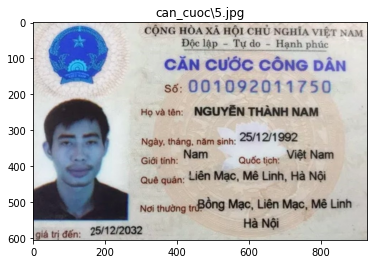

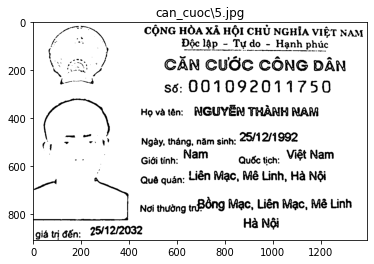

['g', 'căn', 'cước', 'công', 'dân', 'sé', 'ỉ\\', 'họ', 'và', 'tên', 'nguyễn', 'thành', 'cị', 'ngày', 'tháng', 'năm', 'sinh', 'tiinn', 'giới', 'tính', 'quốc', 'tịch', 'quê', 'quán', 'liên', 'mạc', 'mê', 'linh', 'hà', 'nội', 'nơi', 'thường', 'trổng', 'mạc', 'liên', 'mạc', 'mê', 'linh', 'nội', 'giá', 'trị', 'đến', 'hà', 'nội']


In [5]:
# for item in giay_ra_vien:
item = can_cuoc[7]
pprint(item)
image = image_utils.load(item)
plt.imshow(image)
plt.title(item.split('/')[-1])
plt.show()
image = image_utils.pre_process(image)
plt.imshow(image, cmap = 'gray')
plt.title(item.split('/')[-1])
plt.show()

text = tesseract.excecute(image)    
tokens = word_tokenize(text_utils.text_cleaner(text))
tokens = text_utils.fix_tokens(tokens, STOPWORDS)
print(tokens[0:150])

giay_ra_vien = image_utils.load_datasets('../../datasets/image_classify/test/giay_ra_vien/')
giay_phep_lai_xe = image_utils.load_datasets('../../datasets/image_classify/test/giay_phep_lai_xe/')
can_cuoc = image_utils.load_datasets('../../datasets/image_classify/test/can_cuoc/')
cv = image_utils.load_datasets('../../datasets/image_classify/test/cv/')
cavet_xe_may = image_utils.load_datasets('../../datasets/image_classify/test/cavet_xe_may/')
bang_dai_hoc = image_utils.load_datasets('../../datasets/image_classify/test/bang_dai_hoc/')


data_test = []
make_data(data_test, giay_ra_vien, 1)
make_data(data_test, giay_phep_lai_xe, 2)
make_data(data_test, can_cuoc, 3)
make_data(data_test, cv, 4)
make_data(data_test, cavet_xe_may, 5)
make_data(data_test, bang_dai_hoc, 6)

df_test = pd.DataFrame(data_test, columns=columns)
df_test = shuffle(df_test).reset_index(drop=True)
df_test['type'] = ['test' for i in range(df_test.shape[0])]


[34, 25, 2, 21, 29, 35]


Text(0, 0.5, 'Total Sample')

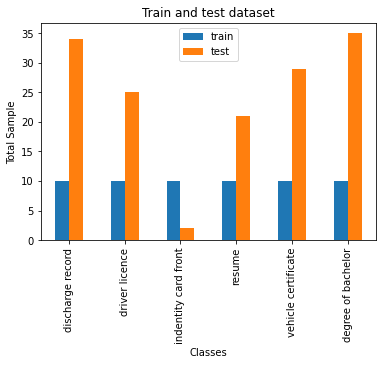

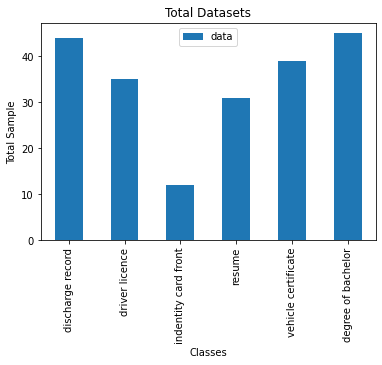

In [6]:
frames = [df_train, df_test]
df = pd.concat(frames)

# make chart
df_train_sum = df_train.groupby('class').count().reset_index(drop=True)
df_test_sum = df_test.groupby('class').count().reset_index(drop=True)
df_sum = df.groupby('class').count().reset_index(drop=True)


X = get_list_class(CLASSES)

TRAIN = list(df_train_sum['image'])
TEST = list(df_test_sum['image'])

pprint(TEST)

plotdata = pd.DataFrame({
    "train": TRAIN,
    "test":TEST,
    }, 
    index=X
)
plotdata.plot(kind="bar")
plt.title("Train and test dataset")
plt.xlabel("Classes")
plt.ylabel("Total Sample")

plotdata = pd.DataFrame({
    "data": list(df_sum['image']),
    }, 
    index=X
)
plotdata.plot(kind="bar")
plt.title("Total Datasets")
plt.xlabel("Classes")
plt.ylabel("Total Sample")

In [8]:
es_utils.delete_elasticsearch_index(es, INDEX_NAME)
es_utils.create_elasticsearch_index(es, INDEX_NAME, LEN_FEATURE)

df = df_train
len_list_task = len(df['image'])
index = 1
pbar = tqdm(total=len_list_task,  position=0, leave=False)

for i in range(len_list_task):
    
    image_path = df['image'][i]
    class_id = df['class'][i]
    image = image_utils.load(image_path)
    image = image_utils.pre_process(image)
    text = tesseract.excecute(image)

    tokens = word_tokenize(text_utils.text_cleaner(text))
    tokens = text_utils.fix_tokens(tokens, STOPWORDS)
    if len(tokens) >= LEN_TOKEN:
        tokens = tokens[0:LEN_TOKEN]
    else:
        for i in range(len(tokens) - LEN_TOKEN):
            tokens.append('None')

    input_ids = torch.tensor([tokenizer.encode(tokens)])
    with torch.no_grad():
        features = phobert(input_ids) 
    es_dim = features['pooler_output'][0].tolist()
    es_utils.create_elasticsearch_datasets(es, INDEX_NAME, class_id, CLASSES[class_id] ,image_path, es_dim, index)
    index += 1
    pbar.update(1)


ConnectionError: ConnectionError((<urllib3.connection.HTTPConnection object at 0x0000023C57927100>, 'Connection to 10.1.32.130 timed out. (connect timeout=10)')) caused by: ConnectTimeoutError((<urllib3.connection.HTTPConnection object at 0x0000023C57927100>, 'Connection to 10.1.32.130 timed out. (connect timeout=10)'))

In [ ]:
from sklearn.metrics import confusion_matrix
import time
start_time = time.time()


df =df_test
x = 0
# confusion_matrix = np.zeros((len(CLASSES), len(CLASSES)))

y_actu = []
y_pred = []

error = []
for i in range(len(df['image'])):
    if i == 20:
        break
    image_path = df['image'][i]
    class_id = df['class'][i]
    
    try:
        image = scanner.process(image_utils.load(image_path))
        image = image_utils.pre_process(image)
        text = tesseract.excecute(image)
    except:
        error.append(image_path)
        continue
    
    tokens = word_tokenize(text_utils.text_cleaner(text))
    tokens = text_utils.fix_tokens(tokens, STOPWORDS)
        
    if len(tokens) >= LEN_TOKEN:
        tokens = tokens[0:LEN_TOKEN]
    else:
        for i in range(len(tokens) - LEN_TOKEN):
            tokens.append('None')
    input_ids = torch.tensor([tokenizer.encode(tokens)])
    with torch.no_grad():
        features = phobert(input_ids) 
    es_dim = features['pooler_output'][0].tolist()
    pred = es_utils.matching_elasticsearch_index(es, INDEX_NAME, es_dim)
   
    hits = pred['hits']['hits']
    score = hits[0]['_score']/2
    class_pre = hits[0]['_source']['id']
    if score < 0.86:
        print('special_case')
        a = {'0': 0, '1':0, '2': 0}
        for i in range(len(hits)):
            a[str(i)] += 1
        max_end = max(a, key=a.get)
        class_pre = hits[int(max_end)]['_source']['id']
    
    y_actu.append(class_id)
    y_pred.append(class_pre)
    
    if class_id == class_pre:
        x += 1
    else:
        print(image_path, class_pre, class_id)
#     confusion_matrix[class_id -1, class_pre -1] += 1
    print("--- %s seconds ---" % (time.time() - start_time))
    
print(x/(len(df['image']) - len(error)))
pprint(error)

# #     df_check = pd.json_normalize(hits)
# #     df_check = df_check[['_source.id', '_score']]
# #     df_check = df_check.rename(columns = {'_source.id': 'id', '_score': 'score'})
# #     df_check = df_check.groupby(["id"], as_index=False).mean()
# #     class_pre = df_check.loc[df_check['score'].idxmax()]['id']

df_show= df['class'].apply(get_class_name)
df_show.value_counts().plot(kind="bar", title="Number of Test Data")

In [ ]:
import seaborn as sn
import numpy as np
y = confusion_matrix(y_actu, y_pred)
columns = []
for key, value in CLASSES.items():
    columns.append(value)
y = y.astype(np.float32)
df_cm = pd.DataFrame(y, index = columns,
                     columns =  columns)
plt.figure(figsize = (len(CLASSES), len(CLASSES)))
sn.heatmap(df_cm, annot=True)

for i in range(len(CLASSES)):
    total = sum(y[i])
    for j in range(len(CLASSES)):
        y[i][j] = y[i][j]/total
df_cm = pd.DataFrame(y, index = columns,
                     columns =  columns)
plt.figure(figsize = (len(CLASSES), len(CLASSES)))
sn.heatmap(df_cm, annot=True)

        
import seaborn as sns
def plot_confusion_matrix(test_y, predict_y, classes):
    """
    This function plots the confusion matrix given predicted and actual values.
    """
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)    
    B =(C/C.sum(axis=0))
    labels = classes
    cmap=sns.light_palette("green")
    # representing A in heatmap format
    plt.figure(figsize=(17,5))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("-"*50, "Confusion matrix", "-"*50)

    plt.figure(figsize=(17,5))
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("-"*50, "Precision matrix", "-"*50)
    
#     print("Sum of columns in precision matrix",B.sum(axis=0))
    
    # representing B in heatmap format
    plt.figure(figsize=(17,5))
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("-"*50, "Recall matrix"    , "-"*50)
#     print("Sum of rows in precision matrix",A.sum(axis=1))
plot_confusion_matrix(y_actu, y_pred, X)